In [ ]:
# edited from DracoCMD.ipynb from Erik ###
from __future__ import print_function
from __future__ import division

import numpy as np
%matplotlib inline
from matplotlib import pyplot as pl

from astropy import table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import votable
from astropy.utils import data
data.conf.remote_timeout = 120 # default is 3 seconds

In [364]:
# load sourcetable, get candidates
sourcetable = table.Table.read('LeoT_like_sources - Sources.csv')
candidates = sourcetable[sourcetable['y/n/m'] == 'y']

# get source and nearby field coordinates
coords = SkyCoord(ra=candidates['ra [deg]'],dec=candidates['dec [deg]'],unit=u.deg,frame='icrs')

lats, longs = coords.galactic.b, coords.galactic.l
lt_longs = longs - 1*u.deg
gt_longs = longs + 1*u.deg
lt_coords = SkyCoord(l=lt_longs,b=lats,unit=u.deg,frame='galactic')
gt_coords = SkyCoord(l=gt_longs,b=lats,unit=u.deg,frame='galactic')

source_radecs = SkyCoord(ra=coords.icrs.ra,dec=coords.icrs.dec,unit=u.deg,frame='icrs')
lt_radecs = SkyCoord(ra=lt_coords.icrs.ra,dec=lt_coords.icrs.dec,unit=u.deg,frame='icrs')
gt_radecs = SkyCoord(ra=gt_coords.icrs.ra,dec=gt_coords.icrs.dec,unit=u.deg,frame='icrs')

# set url/search parameters
url_templ = 'http://gsss.stsci.edu/webservices/vo/CatalogSearch.aspx?CAT=PS1V3OBJECTS&RA={ra}&DEC={dec}&SR={rad}'
search_radius = 5/60. # degrees

8 1401835.228
9 1401835.292


10 1401835.298
11 1401835.305


12 1402635.043


13 1402635.063


14 1561035.044


15 1561835.041


16 2361835.041


17 2362635.041


18 2363435.021


19 2840235.002


20 3321835.278


21 3322635.298


22 3323435.038


23 3403435.022


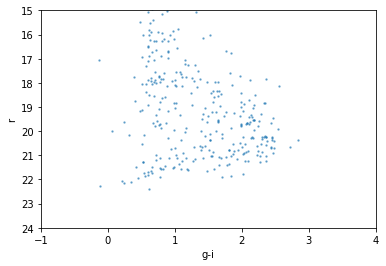

In [369]:
# make CMDs (r vs g=i) for all candidates
# use a VO cone search to get coords and mags of nearby sources
for i in range(len(candidates)):
    print(i,str(candidates['# id'][i]))
    url = url_templ.format(ra=source_radecs[i].ra.deg, 
                           dec=source_radecs[i].dec.deg,
                           rad=search_radius)
    lt_url = url_templ.format(ra=lt_radecs[i].ra.deg, 
                              dec=lt_radecs[i].dec.deg,
                              rad=search_radius)    
    gt_url = url_templ.format(ra=gt_radecs[i].ra.deg, 
                              dec=gt_radecs[i].dec.deg,
                              rad=search_radius)
    # download VO table
    tab = votable.parse_single_table(url).to_table()
    lt_tab = votable.parse_single_table(lt_url).to_table()
    gt_tab = votable.parse_single_table(gt_url).to_table() 
    
    # minor editing to create 'distance' field
    tab['ra'] = tab['RAmean']
    tab['dec'] = tab['DECmean']
    lt_tab['ra'] = lt_tab['RAmean']
    lt_tab['dec'] = lt_tab['DECmean']
    gt_tab['ra'] = gt_tab['RAmean']
    gt_tab['dec'] = gt_tab['DECmean']
    
    sc = SkyCoord.guess_from_table(tab,unit=u.deg)
    lt_sc = SkyCoord.guess_from_table(lt_tab,unit=u.deg)
    gt_sc = SkyCoord.guess_from_table(gt_tab,unit=u.deg)

    tab['dist'] = source_radecs[i].separation(sc).to(u.arcmin)
    lt_tab['dist'] = lt_radecs[i].separation(lt_sc).to(u.arcmin)
    gt_tab['dist'] = gt_radecs[i].separation(gt_sc).to(u.arcmin)

    # separate stars from galaxies (https://confluence.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies)
    star_tab = tab[tab['iMeanPSFMag']-tab['iMeanKronMag'] < 0.05]
    star_tab_lt = lt_tab[lt_tab['iMeanPSFMag']-lt_tab['iMeanKronMag'] < 0.05]
    star_tab_gt = gt_tab[gt_tab['iMeanPSFMag']-gt_tab['iMeanKronMag'] < 0.05]
    
    # make CMDs
    m_tab = star_tab[star_tab['dist']<5]
    m_tab = m_tab[m_tab['gMeanPSFMag'] != -999]
    color = m_tab['gMeanPSFMag'] - m_tab['iMeanPSFMag']
    mag = m_tab['rMeanPSFMag']
    pl.clf()
    pl.scatter(color, mag, alpha=0.5, s=2)
    pl.xlabel('g-i')
    pl.ylabel('r')
    pl.ylim(24,15)
    pl.xlim(-1,4)
    pl.savefig('/Users/daniel/Desktop/Candidate_CMDs/'+str(candidates['# id'][i])+'_rVSg-i.pdf')
    
    lt_m_tab = star_tab_lt[star_tab_lt['dist']<5]
    lt_m_tab = lt_m_tab[lt_m_tab['gMeanPSFMag'] != -999]
    lt_color = lt_m_tab['gMeanPSFMag'] - lt_m_tab['iMeanPSFMag']
    lt_mag = lt_m_tab['rMeanPSFMag']
    pl.clf()
    pl.scatter(lt_color, lt_mag, alpha=0.5, s=2)
    pl.xlabel('g-i')
    pl.ylabel('r')
    pl.ylim(24,15)
    pl.xlim(-1,4)
    pl.savefig('/Users/daniel/Desktop/Candidate_CMDs/'+str(candidates['# id'][i])+'_lt_rVSg-i.pdf')
    
    gt_m_tab = star_tab_gt[star_tab_gt['dist']<5]
    gt_m_tab = gt_m_tab[gt_m_tab['gMeanPSFMag'] != -999]
    gt_color = gt_m_tab['gMeanPSFMag'] - gt_m_tab['iMeanPSFMag']
    gt_mag = gt_m_tab['rMeanPSFMag']
    pl.clf()
    pl.scatter(gt_color, gt_mag, alpha=0.5, s=2)
    pl.xlabel('g-i')
    pl.ylabel('r')
    pl.ylim(24,15)
    pl.xlim(-1,4)
    pl.savefig('/Users/daniel/Desktop/Candidate_CMDs/'+str(candidates['# id'][i])+'_gt_rVSg-i.pdf')